# Definitions

October 9, 2017

In [1]:
# General definitions
%run '../definitions.ipynb'
%run '../treemakers/treemakers.py'
%run '../Analysis_class.ipynb'

#### Data location

In [2]:
processed_data_path = '/data/xenon/xams/run8/processed_v2_medium/'
processed_data_path_2 = '/data/xenon/xams/run8/processed_v2/'
minitree_path = '/data/xenon/xams/run8/minitrees/'

In [3]:
run_names_ambe_1 = get_run_list(processed_data_path, '170324_161817', '170324_215007') # Last file: 170322_081037
run_names_ambe_2 = get_run_list(processed_data_path_2, '170324_222017', '170327_070907') # Last file: 170327_070907
run_names_cs = get_run_list(processed_data_path, '170327_080108', '170327_095258')

Run list contains 12 files
Run list contains 104 files
Run list contains 12 files


In [4]:
treemakers = ['Fundamentals', ZeroFieldProperties]

#### Read function

In [5]:
def read_and_cut(run_names, processed_data_path, minitree_path, treemakers = None, cut=True, **kwargs):
    if 'pickle_file' in kwargs.keys():
        if not kwargs.get('force_reload', False):
            try:
                with open(kwargs['pickle_file'], 'rb') as f:
                    x = pickle.load(f)
                print('Read %d events from file %s' % (len(x.d), kwargs['pickle_file']))
                return x
            except:
                print('Pickle not found, now starting loading...')
                
    x = XAMSAnalysis(run_names, processed_data_path, minitree_path)    
    x.load(treemakers = treemakers, compute_properties=False)
    
    # Add properties
    x.d['s1'] = x.d['s1_area']
    x.add_z_from_s1_aft()
    x.corr_s1_ly_poly(ly_filename='../light_yield/data/cs137_ly_p2_sel2.pickle')
    x.add_g1g2_props(pickle_file='../light_yield/data/doke_sel2_ext.pickle')
    
    # Cuts
    if cut:
        x.cut_time_since_previous(apply=True)
        x.d = cuts.below(x.d, 'n_s1s', 2)
        x.d = cuts.above(x.d, 'n_s1s', 0)
        x.cut_fiducial_volume()
        
    if 'pickle_file' in kwargs.keys():
        with open(kwargs['pickle_file'], 'wb') as f:
            pickle.dump(x, f)

    return x

### Read data

In [6]:
ambe = read_and_cut(run_names_ambe_1, processed_data_path, minitree_path, treemakers=treemakers, 
                    compute_properties=False, cut=False, 
                    pickle_file = '/home/erik/win/data/xams_run8/zero_field_ambe_first_6h_uncut.pickle')
# cs = read_and_cut(run_names_cs, processed_data_path, minitree_path, treemakers=treemakers, 
#                   cut=False, compute_properties=False, 
#                   pickle_file = '/home/erik/win/data/xams_run8/zero_field_cs_uncut.pickle')

Read 2909296 events from file /home/erik/win/data/xams_run8/zero_field_ambe_first_6h_uncut.pickle


In [7]:
ambe_2 = read_and_cut(run_names_ambe_2[-12:], processed_data_path_2, minitree_path, treemakers=treemakers, 
                    compute_properties=False, cut=False, 
                      pickle_file = '/home/erik/win/data/xams_run8/zero_field_ambe_last_6h_uncut.pickle')

Read 2859689 events from file /home/erik/win/data/xams_run8/zero_field_ambe_last_6h_uncut.pickle


# Analysis of the cuts

### Energy spectrum

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


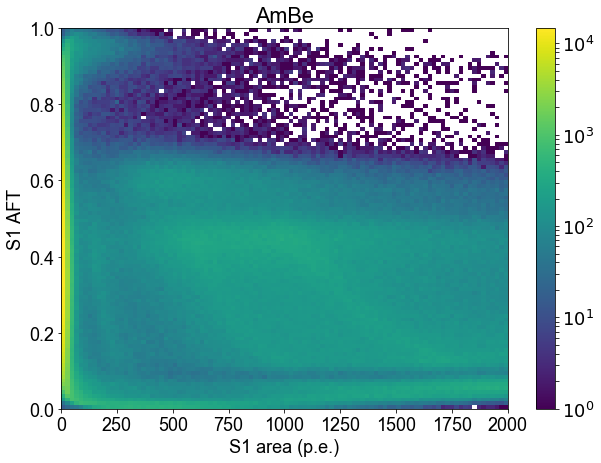

In [8]:
plt.hist2d(ambe_2.d['s1_area'], ambe_2.d['s1_area_fraction_top'], bins=100, norm=LogNorm(),
          range=((0, 2000), (0, 1)))
plt.ylabel('S1 AFT')
plt.xlabel('S1 area (p.e.)')
plt.colorbar()
plt.title('AmBe')
plt.show()

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


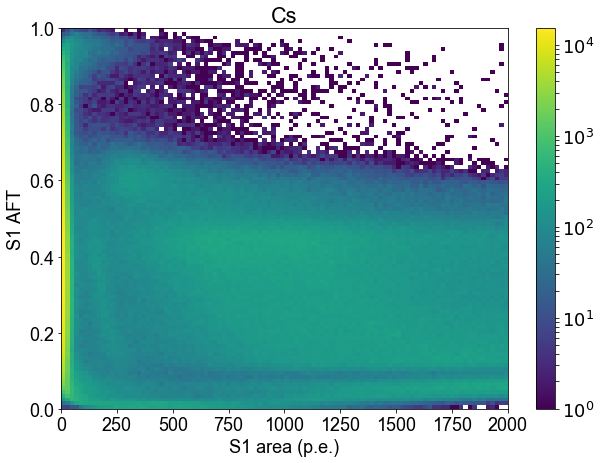

In [10]:
plt.hist2d(cs.d['s1_area'], cs.d['s1_area_fraction_top'], bins=100, norm=LogNorm(),
          range=((0, 2000), (0, 1)))
plt.ylabel('S1 AFT')
plt.xlabel('S1 area (p.e.)')
plt.colorbar()
plt.title('Cs')
plt.show()

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


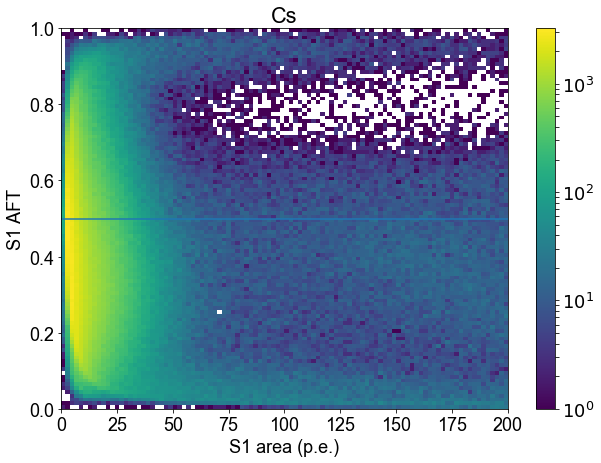

In [15]:
plt.hist2d(cs.d['s1_area'], cs.d['s1_area_fraction_top'], bins=100, norm=LogNorm(),
          range=((0, 200), (0, 1)))
plt.ylabel('S1 AFT')
plt.xlabel('S1 area (p.e.)')
plt.colorbar()
plt.title('Cs')
plt.axhline(0.5)
plt.show()

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


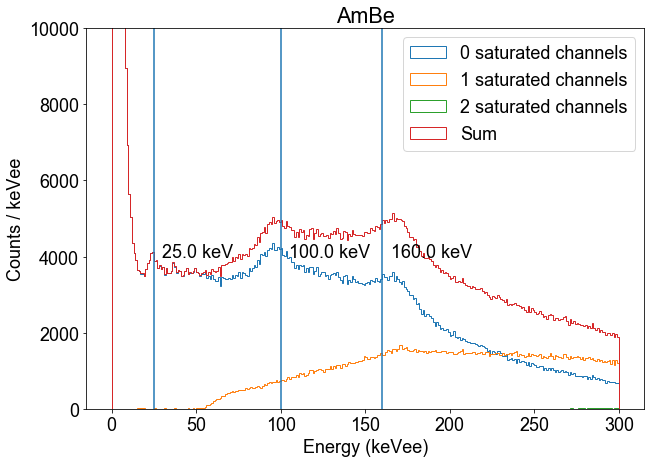

In [16]:
for n_channels_sat in [0, 1, 2]:
    sel = ambe.d['s1_n_saturated_channels'] == n_channels_sat
    plt.hist(ambe.d['e_ces'][sel], bins=300, range=(0, 300), histtype='step', 
             label='%d saturated channels' % n_channels_sat)
    plt.ylim(0, 10e3)
plt.hist(ambe.d['e_ces'], bins=300, range=(0, 300), histtype='step', label='Sum')
for _l in (25, 100, 160):
    plt.axvline(_l)
    plt.text(_l+ 5, 4000, '%.1f keV' % _l)
plt.legend()
plt.xlabel('Energy (keVee)')
plt.ylabel('Counts / keVee')
plt.title('AmBe')

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


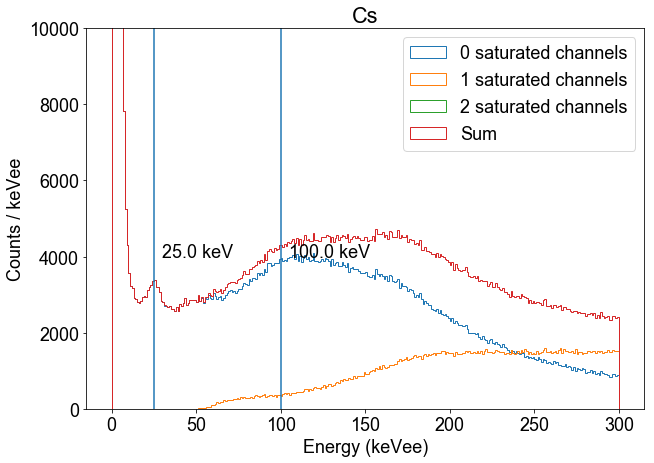

In [17]:
for n_channels_sat in [0, 1, 2]:
    sel = cs.d['s1_n_saturated_channels'] == n_channels_sat
    plt.hist(cs.d['e_ces'][sel], bins=300, range=(0, 300), histtype='step', 
             label='%d saturated channels' % n_channels_sat)
    plt.ylim(0, 10e3)
plt.hist(cs.d['e_ces'], bins=300, range=(0, 300), histtype='step', label='Sum')
for _l in (25, 100):
    plt.axvline(_l)
    plt.text(_l+ 5, 4000, '%.1f keV' % _l)
plt.legend()
plt.xlabel('Energy (keVee)')
plt.ylabel('Counts / keVee')
plt.title('Cs')

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


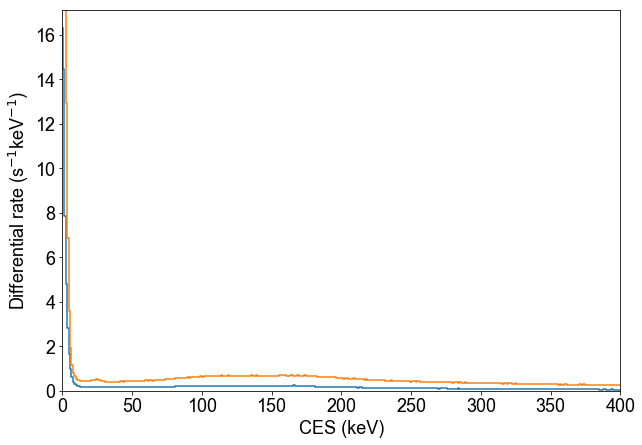

In [18]:
for x in (ambe, cs):
    x.plot_ces_rate()

plt.show()

In [19]:
cs.livetime

6636.3508414240005

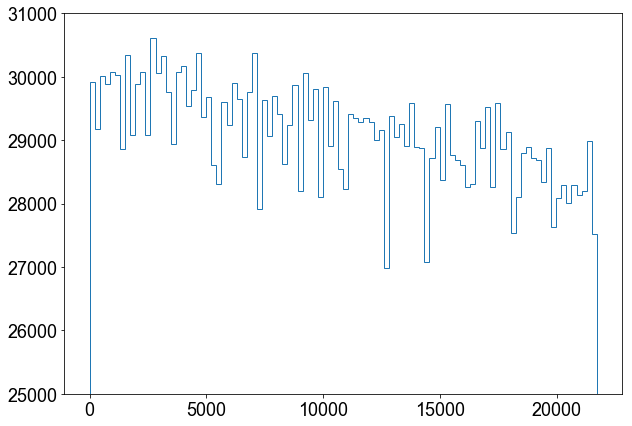

In [20]:
plt.hist(ambe.d['t'], bins=100, histtype='step')
plt.ylim(25e3, 31e3)
plt.show()

### Livetime correction to time since previous cut

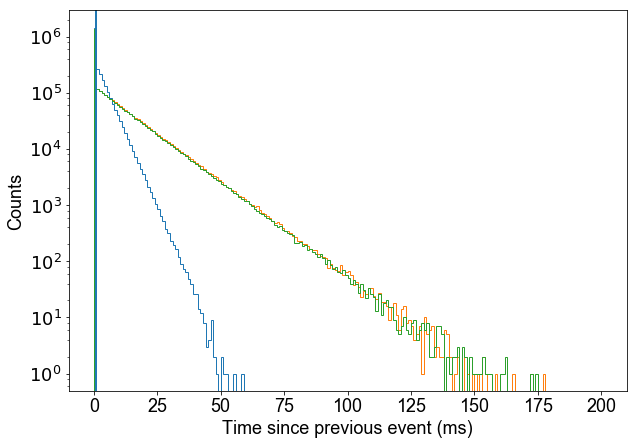

In [21]:
for x in (cs, ambe, ambe_2):
    x.cut_time_since_previous(apply=False, plot=True, bins=200, range=(0, 200), histtype='step')
plt.yscale('log')
plt.show()

In [22]:
def exp_decay(x, tau):
    return np.exp(-x/tau)

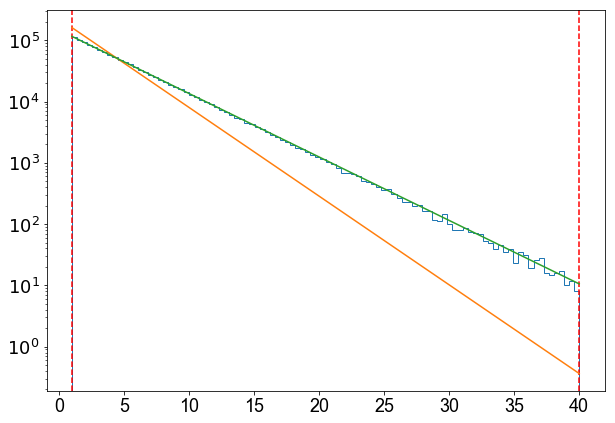

In [23]:
tau_cs, dtau_cs, _ = fit_unbinned(cs.d['ms_since_previous_event'], exp_decay, p0=[3.], 
                                  fit_range=(1, 40), plot=True, print_level=0)
plt.yscale('log')


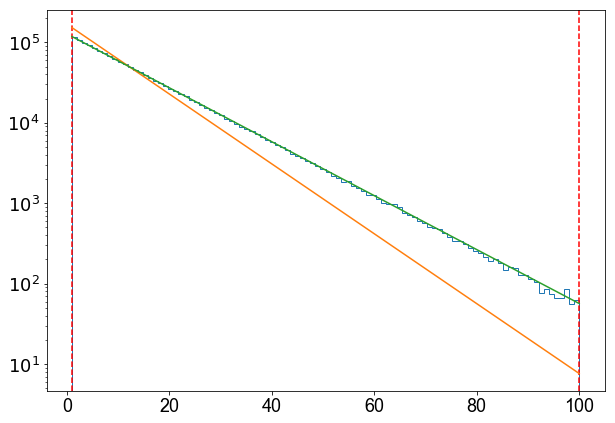

In [24]:
tau_ambe, dtau_ambe, _ = fit_unbinned(ambe.d['ms_since_previous_event'], exp_decay, p0=[10.], 
                                  fit_range=(1, 100), plot=True, print_level=0)
plt.yscale('log')


In [25]:
tau_ambe = tau_ambe[0]
tau_cs = tau_cs[0]

In [26]:
rate_ambe = 1 / (0.001 * tau_ambe)
rate_cs = 1 / (0.001 * tau_cs)

In [27]:
print('Rate found for AmBe: %.1f Hz. Actual rate: %.1f Hz' % (rate_ambe, ambe.rate))
print('Rate found for Cs:   %.1f Hz. Actual rate: %.1f Hz' % (rate_cs, cs.rate))

Rate found for AmBe: 77.2 Hz. Actual rate: 134.7 Hz
Rate found for Cs:   238.5 Hz. Actual rate: 407.9 Hz


In [128]:
def compute_lifetime_fraction_cut(tau, cut_value):
    '''
    Old-fashined integrals and exact solutions to the rescue!
    '''
    return 1 - np.exp(- cut_value / tau)

In [133]:
compute_lifetime_fraction_cut(tau_ambe, 1)

0.07427951921420195

In [134]:
compute_lifetime_fraction_cut(tau_cs, 1)

0.21219427268584701

# Extracting The Waveforms

Given the cuts, let's read the data and get the waveform

In [7]:
cs = read_and_cut(run_names_cs, processed_data_path, minitree_path, treemakers=treemakers, 
                  cut=False, compute_properties=False, 
                  pickle_file = '/home/erik/win/data/xams_run8/zero_field_cs_uncut.pickle')

Read 2706931 events from file /home/erik/win/data/xams_run8/zero_field_cs_uncut.pickle


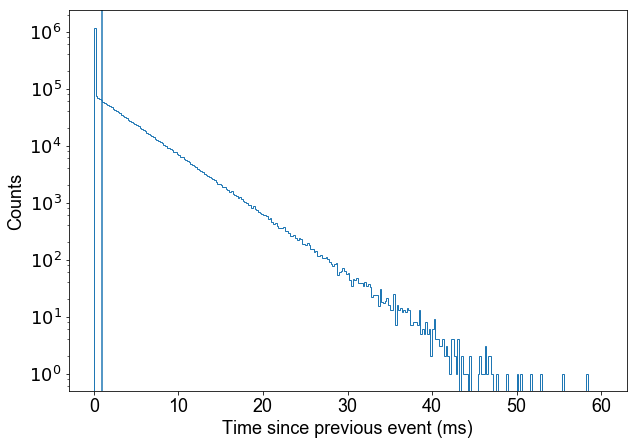

In [8]:
cs.cut_time_since_previous(plot=True, apply=True, bins=300, range=(0, 60), histtype='step')
plt.yscale('log')
plt.show()

In [9]:
cs.d = cuts.below(cs.d, 's1_n_saturated_channels', 1)

In [10]:
cs.d = cuts.selection(cs.d, cs.d['n_s1s'] == 1, 'One S1')

In [11]:
cs.cut_fiducial_volume()

In [12]:
cuts.history(cs.d)

,selection_desc,n_before,n_after,n_removed,fraction_passed,cumulative_fraction_left
0,ms_since_previous_event above 1.0,2706931,1257569,1449362,0.464574,0.464574
1,s1_n_saturated_channels below 1,1257569,713252,544317,0.567167,0.263491
2,One S1,713252,698895,14357,0.979871,0.258187
3,"z in [-9.5, -0.5)",698895,395450,303445,0.565822,0.146088


In [13]:
cs.livetime

6636.3508414240005

In [7]:
ambe.filenames

['170324_161817',
 '170324_164827',
 '170324_171837',
 '170324_174847',
 '170324_181857',
 '170324_184907',
 '170324_191917',
 '170324_194927',
 '170324_201937',
 '170324_204947',
 '170324_211957',
 '170324_215007']

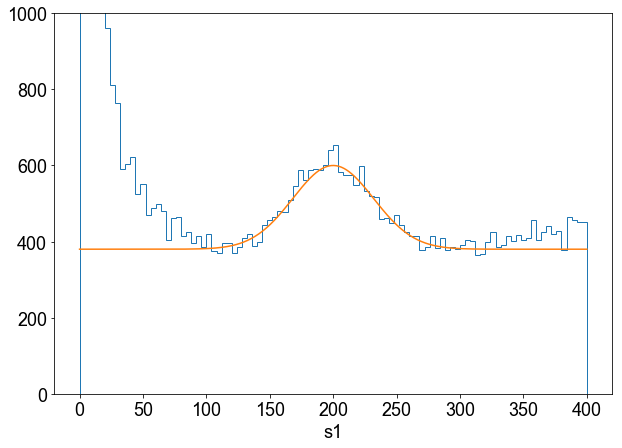

In [15]:
# plt.hist(cs.d['s1'], bins=100, range=(0, 1000), histtype='step')
plt.hist(cs.d['cs1'], bins=100, range=(0, 400), histtype='step')
plt.ylim(0, 1000)
x_plot  = np.linspace(0, 400, 400)
plt.plot(x_plot, gaus_with_bg(x_plot, 220, 200, 45, 380, 0))
plt.xlabel('s1')
plt.show()

In [8]:
hax.init(
    # Always use these lines to tell hax that we don't care about Xe1T
    experiment='XAMS', 
    pax_version_policy='loose', use_runs_db = False,
    # Here come the useful settings
    main_data_paths = [processed_data_path],
    minitree_paths = [minitree_path],
    preferred_minitree_format = 'pklz'
 )

INFO:hax.__init__] Not looking for datasets in runs, db since you put use_runs_db = False


In [9]:
# Artificial Low-acc cut to keep memory happy for now

In [10]:
ambe.d = ambe.d[ambe.d['event_number'] % 10000 == 1]

In [11]:
ambe.add_s1_waveforms(zerofield=True, verbose=True)

170324_161817
170324_164827
170324_171837


DEBUG:hax.minitrees] Found minitree at /data/xenon/xams/run8/minitrees/170324_174847_S1PulseZeroField.pklz


170324_174847


DEBUG:hax.minitrees] Found minitree at /data/xenon/xams/run8/minitrees/170324_174847_S1PulseZeroField.pklz
/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:198: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['s1_pulse']]

DEBUG:hax.minitrees] Found minitree at /data/xenon/xams/run8/minitrees/170324_181857_S1PulseZeroField.pklz


170324_181857


DEBUG:hax.minitrees] Found minitree at /data/xenon/xams/run8/minitrees/170324_181857_S1PulseZeroField.pklz
DEBUG:hax.minitrees] Found minitree at /data/xenon/xams/run8/minitrees/170324_184907_S1PulseZeroField.pklz


170324_184907


DEBUG:hax.minitrees] Found minitree at /data/xenon/xams/run8/minitrees/170324_184907_S1PulseZeroField.pklz
DEBUG:hax.minitrees] Found minitree at /data/xenon/xams/run8/minitrees/170324_191917_S1PulseZeroField.pklz


170324_191917


DEBUG:hax.minitrees] Found minitree at /data/xenon/xams/run8/minitrees/170324_191917_S1PulseZeroField.pklz
DEBUG:hax.minitrees] Found minitree at /data/xenon/xams/run8/minitrees/170324_194927_S1PulseZeroField.pklz


170324_194927


DEBUG:hax.minitrees] Found minitree at /data/xenon/xams/run8/minitrees/170324_194927_S1PulseZeroField.pklz
DEBUG:hax.minitrees] Found minitree at /data/xenon/xams/run8/minitrees/170324_201937_S1PulseZeroField.pklz


170324_201937


DEBUG:hax.minitrees] Found minitree at /data/xenon/xams/run8/minitrees/170324_201937_S1PulseZeroField.pklz
DEBUG:hax.minitrees] Found minitree at /data/xenon/xams/run8/minitrees/170324_204947_S1PulseZeroField.pklz


170324_204947


DEBUG:hax.minitrees] Found minitree at /data/xenon/xams/run8/minitrees/170324_204947_S1PulseZeroField.pklz
DEBUG:hax.minitrees] Found minitree at /data/xenon/xams/run8/minitrees/170324_211957_S1PulseZeroField.pklz


170324_211957


DEBUG:hax.minitrees] Found minitree at /data/xenon/xams/run8/minitrees/170324_211957_S1PulseZeroField.pklz
DEBUG:hax.minitrees] Found minitree at /data/xenon/xams/run8/minitrees/170324_215007_S1PulseZeroField.pklz


170324_215007


DEBUG:hax.minitrees] Found minitree at /data/xenon/xams/run8/minitrees/170324_215007_S1PulseZeroField.pklz


In [ ]:
cs.add_percentiles()

In [24]:
with open('zerofield_dataframes.pickle', 'wb') as f:
    pickle.dump(cs.d, f)

### Plot average wv

In [39]:
def build_pulse_hist_entries(d, alignment_field):
    '''
    Align the S1 pulses. This assumes 400 ns of data and a field (`alignment_field`) that is given in units of 
    time since start of waveform in ns. This is put at the zero point, which is 100 ns in the waveform.
    The function returns two arrays, one containing the time points (shifted by the alignment field) and 
    one containing the weight, so that lower-than 1 bin sampling and alignment is possible.
    '''
    time_edges = np.linspace(-100, 300, 201)
    # Arbitrarily put the first sample EXACTLY at zero rather than at bin edges
    time = time_edges[:-1]
    time_entries = []
    weight_entries = []
    
    for i, ev in d.iterrows():
        time_entries.append(time + 100 - ev[alignment_field])
        weight_entries.append(np.array(ev['s1_pulse']) / ev['s1'])
    
    return np.concatenate(time_entries), np.concatenate(weight_entries)

def compute_average_pulse(d, alignment_field, dt = 2):
    '''
    Compute the average pulse, calling the underlying `build_pulse_hist_entries` routine. 
    This assumes 400 ns of data and a field (`alignment_field`) that is given in units of 
    time since start of waveform in ns. This is put at the zero point, which is 100 ns in the waveform.
    dt is sample time in ns, which may be lower than the raw sample of 2 ns. Go ahead and try!
    '''
    n_bins_time = np.floor(400 / dt) + 1
    if 400 % dt:
        print('Warning: please use a divisor of 400 for your time bins (i.e. 1, 0.2, 200, ...) .')
    time_edges = np.linspace(-100, 300, n_bins_time)
    times, weights = build_pulse_hist_entries(d, alignment_field)
    
    # This takes only the left bin edges, so that the first sample is zero.
    time = time_edges[:-1]
    amplitude, _ = np.histogram(times, bins=time_edges, weights=weights)
    # Normalization
    amplitude = amplitude / len(d) / dt
    
    return time, amplitude

def plot_average_pulse_in_slice(d, alignment_field, slice_field = 'cs1', dt = 2, slice_range=(0, np.inf), **kwargs):
    sel = (d[slice_field] >= slice_range[0]) & (d[slice_field] < slice_range[1])
    time, average_pulse = compute_average_pulse(d[sel], alignment_field, dt)
    plt.plot(time, average_pulse, **kwargs)
    plt.xlabel('Time (ns)')
    plt.ylabel('Average pulse ((%d ns)$^{-1}$)' % dt)
    return time, average_pulse

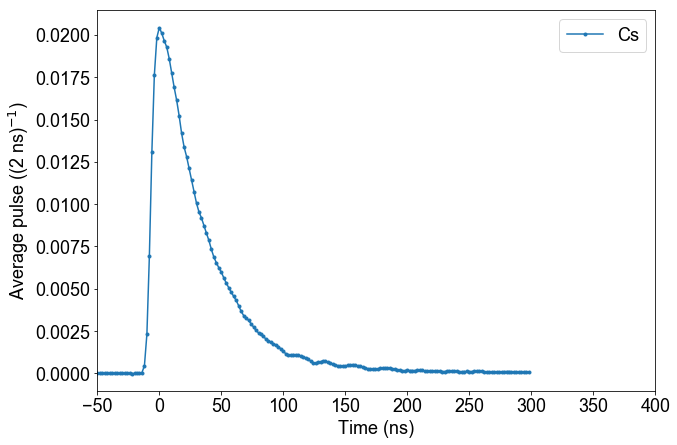

In [42]:
t, pulse = plot_average_pulse_in_slice(cs.d, 's1_10_percentile_point', dt=2, slice_field = 's1',
                            slice_range=(400, 500), label='Cs', marker='.')
# plot_average_pulse_in_slice(er_ersel.d, 's1_10_percentile_point', dt=2, cs1_range=(30, 40), label='ER', marker='.')

plt.xlim(-50, 400)
plt.legend()
# plt.yscale('log')
plt.show()

In [ ]:
exp_shift = 